In [1]:
library(tidyverse)
library(catboost)
library(h2o)
library(lightgbm)
library(pROC)
library(caret)
library(themis)
library(tidymodels)
# library(missForest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse,

In [2]:
#helper function for multiplot
# Multiple plot function
# 
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
# http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

options(repr.plot.width = 14, repr.plot.height = 8)

In [3]:
train <- read_csv("../input/jobathon-may-2021-credit-card-lead-prediction//train.csv")
test <- read_csv("../input//jobathon-may-2021-credit-card-lead-prediction//test.csv")
sample_sub <- read_csv("../input//jobathon-may-2021-credit-card-lead-prediction//sample_submission.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Gender = col_character(),
  Age = col_double(),
  Region_Code = col_character(),
  Occupation = col_character(),
  Channel_Code = col_character(),
  Vintage = col_double(),
  Credit_Product = col_character(),
  Avg_Account_Balance = col_double(),
  Is_Active = col_character(),
  Is_Lead = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Gender = col_character(),
  Age = col_double(),
  Region_Code = col_character(),
  Occupation = col_character(),
  Channel_Code = col_character(),
  Vintage = col_double(),
  Credit_Product = col_character(),
  Avg_Account_Balance = col_double(),
  Is_Active = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  Is_Lead = col_double()
)




In [4]:
train <- train %>% select(-ID) %>% mutate_if(is.character,as.factor) 
test <- test %>% select(-ID) %>% mutate_if(is.character,as.factor)

#Univariate Analysis
p1 <- train %>% ggplot(aes(Gender,fill=factor(Is_Lead)))+geom_bar(stat="count")
p2 <- train %>% ggplot(aes(Region_Code,fill=factor(Is_Lead)))+geom_bar(stat="count")+
theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))
p3 <- train %>% ggplot(aes(Occupation,fill=factor(Is_Lead)))+geom_bar(stat="count")
p4 <- train %>% ggplot(aes(Credit_Product,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
p5 <- train %>% ggplot(aes(Occupation,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
p6 <- train %>% ggplot(aes(Is_Active,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
multiplot(p1, p2, p3, p4, p5, p6, cols=3)

p7 <- train %>% ggplot(aes(Channel_Code,fill=factor(Is_Lead)))+geom_bar(stat="count",position="fill")
p8 <- train %>% ggplot(aes(Channel_Code,fill=factor(Is_Lead)))+geom_bar(stat="count")

p9 <- train %>% ggplot(aes(Channel_Code,fill=Occupation))+geom_bar(stat="count")
p10 <- train %>% ggplot(aes(Channel_Code,fill=Credit_Product))+geom_bar(stat="count")


p11 <- train %>% ggplot(aes(Channel_Code,fill=Occupation))+geom_bar(stat="count",position="fill")+facet_grid(~factor(Is_Lead))
p12 <- train %>% ggplot(aes(Channel_Code,fill=Credit_Product))+geom_bar(stat="count",position="fill")+facet_grid(~factor(Is_Lead))
multiplot(p7,p8,p9,p10,p11,p12, cols=2)

p1 <- train %>% ggplot(aes(Age,fill=factor(Is_Lead)))+geom_density(alpha=0.8) #important
p2 <- train %>% ggplot(aes(Vintage,fill=factor(Is_Lead)))+geom_density(alpha=0.8)#important
p3 <- train %>% ggplot(aes(Age,fill=Occupation))+geom_density(alpha=0.8)#important
p4 <- train %>% ggplot(aes(Vintage,fill=Occupation))+geom_density(alpha=0.8)#important
p5 <- train %>% ggplot(aes(Age,fill=Channel_Code))+geom_density(alpha=0.6)#important
p6 <- train %>% ggplot(aes(Vintage,fill=Channel_Code))+geom_density(alpha=0.8)#important
layout <- matrix(c(1,2,3,4,5,6),3,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, p5, p6, layout = layout)

p1 <- train %>% ggplot(aes(Age,fill=Gender))+geom_density(alpha=0.6) #important
p2 <- train %>% ggplot(aes(Vintage,fill=Gender))+geom_density(alpha=0.6)#important
p3 <- train %>% ggplot(aes(Age,fill=Credit_Product))+geom_density(alpha=0.6)#important
p4 <- train %>% ggplot(aes(Vintage,fill=Credit_Product))+geom_density(alpha=0.6)#important
p5 <- train %>% ggplot(aes(Age,fill=Is_Active))+geom_density(alpha=0.6)#important
p6 <- train %>% ggplot(aes(Vintage,fill=Is_Active))+geom_density(alpha=0.6)#important
layout <- matrix(c(1,2,3,4,5,6),3,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, p5, p6, layout = layout)

p1 <- train %>% ggplot(aes(Age,fill=Occupation))+geom_density(alpha=0.8)+facet_grid(~factor(Is_Lead))
p2 <- train %>% ggplot(aes(Vintage,fill=Occupation))+geom_density(alpha=0.8)+facet_grid(~factor(Is_Lead))
p3 <- train %>% ggplot(aes(Vintage,fill=Credit_Product))+geom_density(alpha=0.6)+facet_grid(~factor(Is_Lead))#important
p4 <- train %>% ggplot(aes(Age,fill=Credit_Product))+geom_density(alpha=0.6)+facet_grid(~factor(Is_Lead))#important
multiplot(p1, p2, p3, p4, cols=2)

p1 <- train %>% ggplot(aes(factor(Is_Lead),Age,fill=Occupation))+geom_boxplot()#important
p2 <- train %>% ggplot(aes(factor(Is_Lead),Age,fill=Channel_Code))+geom_boxplot()#important
p3 <- train %>% ggplot(aes(factor(Is_Lead),Vintage,fill=Occupation))+geom_boxplot()#important
p4 <- train %>% ggplot(aes(factor(Is_Lead),Vintage,fill=Channel_Code))+geom_boxplot()#important
multiplot(p1, p2, p3, p4, cols=2)

train %>% ggplot(aes(Occupation,Age,fill=factor(Is_Lead)))+geom_violin()
train %>% ggplot(aes(Channel_Code,Age,fill=factor(Is_Lead)))+geom_violin()

# Pre-Processing & Modelling

We will be fixing the missing values in 2 ways,
1. Using missForest
2. Using Recipe baggedImputes
3. Running a smaller model to predict the missing values using lightgbm or catboost or h2o
4. imputing -999

We can fix imbalance class using 
1. SMOTE / ROSE
2. Using the algorithm inbuild way balacing way

In [5]:
train <- train %>% mutate(Is_Lead=factor(Is_Lead))

In [6]:
tr_split <- initial_split(train,prop=0.8,strata = Is_Lead,breaks = 4)
tr_split

<Analysis/Assess/Total>
<196581/49144/245725>

In [7]:
tr_sample <- training(tr_split)
va_sample <- testing(tr_split)
folds <- vfold_cv(tr_sample,v=5)
str(tr_sample)

tibble[,10] [196,581 × 10] (S3: tbl_df/tbl/data.frame)
 $ Gender             : Factor w/ 2 levels "Female","Male": 1 1 1 1 2 2 1 1 2 1 ...
 $ Age                : num [1:196581] 73 30 56 30 56 62 48 55 53 27 ...
 $ Region_Code        : Factor w/ 35 levels "RG250","RG251",..: 19 28 19 33 12 33 16 19 5 28 ...
 $ Occupation         : Factor w/ 4 levels "Entrepreneur",..: 2 3 4 3 4 2 4 4 4 3 ...
 $ Channel_Code       : Factor w/ 4 levels "X1","X2","X3",..: 3 1 3 1 1 3 3 2 3 1 ...
 $ Vintage            : num [1:196581] 43 32 26 33 32 20 13 49 123 20 ...
 $ Credit_Product     : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 NA 1 2 1 1 ...
 $ Avg_Account_Balance: num [1:196581] 1045696 581988 1484315 886787 544163 ...
 $ Is_Active          : Factor w/ 2 levels "No","Yes": 1 1 2 1 2 2 2 1 2 2 ...
 $ Is_Lead            : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 1 1 ...


In [8]:
#recipe bagged impute
bagg_impute <- tr_sample %>% 
    recipe(Is_Lead~.) %>% 
    step_log(Avg_Account_Balance) %>%
    step_impute_bag(Credit_Product,
                    impute_with = imp_vars(Age,Vintage,Occupation,
                                           Channel_Code),
                   options = list(nbagg = 10, keepX = FALSE))

In [9]:
def_bagg_impute <- bagg_impute %>%
    step_dummy(all_nominal(),-all_outcomes()) %>%
    step_nzv(all_predictors())

rose_bagg_impute <- def_bagg_impute %>%
    step_rose(Is_Lead)

In [10]:
tr_s <- bake(prep(rose_bagg_impute),new_data = NULL)
str(tr_s)

tibble[,18] [299,900 × 18] (S3: tbl_df/tbl/data.frame)
 $ Age                     : num [1:299900] 30.7 18.6 34.6 68.6 56.8 ...
 $ Vintage                 : num [1:299900] 23.5 17.2 36.3 11.8 39.1 ...
 $ Avg_Account_Balance     : num [1:299900] 12.5 14.3 14.3 13.4 14.5 ...
 $ Is_Lead                 : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Gender_Male             : num [1:299900] -0.201 -0.429 1.124 1.375 1.191 ...
 $ Region_Code_RG254       : num [1:299900] -0.0771 0.1066 0.9911 -0.0516 -0.0189 ...
 $ Region_Code_RG268       : num [1:299900] 0.5253 -0.1409 0.0829 0.0362 -0.0326 ...
 $ Region_Code_RG277       : num [1:299900] -0.1351 1.1434 0.0117 0.0106 0.1418 ...
 $ Region_Code_RG280       : num [1:299900] 0.1457 0.1468 0.1022 0.178 0.0262 ...
 $ Region_Code_RG283       : num [1:299900] -0.075 0.0241 -0.0659 -0.1406 0.0628 ...
 $ Region_Code_RG284       : num [1:299900] 0.11543 -0.15852 -0.03404 0.22485 -0.00736 ...
 $ Occupation_Other        : num [1:299900] 0.1835 -

In [11]:
va_s <- bake(prep(rose_bagg_impute),new_data = va_sample)

In [12]:
te_s <- bake(prep(def_bagg_impute),new_data = test)
head(te_s)

Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG254,Region_Code_RG268,Region_Code_RG277,Region_Code_RG280,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Credit_Product_Yes,Is_Active_Yes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29,25,13.51760,1,1,0,0,0,0,0,1,0,0,0,0,1,0
43,49,13.73813,1,0,1,0,0,0,0,1,0,0,1,0,1,0
31,14,12.28280,1,0,0,0,0,0,0,0,1,0,0,0,0,0
29,33,13.67403,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29,19,13.39557,0,0,0,0,0,0,0,1,0,0,0,0,0,0
60,110,15.34683,1,0,1,0,0,0,0,0,0,1,0,1,0,0


Preparing the dataset for LGBM / CATBOOST / H2O

In [13]:
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/Rtmp2ZfWxr/filee557b4d98/h2o_UnknownUser_started_from_r.out
    /tmp/Rtmp2ZfWxr/filee5af6e867/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 261 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    1 year, 1 month and 25 days !!! 
    H2O cluster name:           H2O_started_from_R_root_pdz870 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.00 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (1 year, 1 month and 25 days)!
Please download and install the latest version from http://h2o.ai/download/”


In [14]:
#h20
tr_dd <- as.h2o(tr_s)
va_dd <- as.h2o(va_s)
te_dd <- as.h2o(te_s)

X <- colnames(te_s)
Y <- "Is_Lead"
X

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


[1] "Age"                      "Vintage"                 
 [3] "Avg_Account_Balance"      "Gender_Male"             
 [5] "Region_Code_RG254"        "Region_Code_RG268"       
 [7] "Region_Code_RG277"        "Region_Code_RG280"       
 [9] "Region_Code_RG283"        "Region_Code_RG284"       
[11] "Occupation_Other"         "Occupation_Salaried"     
[13] "Occupation_Self_Employed" "Channel_Code_X2"         
[15] "Channel_Code_X3"          "Credit_Product_Yes"      
[17] "Is_Active_Yes"

In [15]:
almname <- paste('ak_h2o_automl',format(Sys.time(),"%d%H%M%S"),sep = '_')
autoML <- h2o.automl(X,Y,training_frame = tr_dd,
                     validation_frame = va_dd,seed=223, 
                     max_models=10,stopping_metric=c("AUC"),balance_classes=TRUE)

  |                                                                      |   0%
  |======================================================================| 100%


In [16]:
autoML@leader

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_AllModels_AutoML_20210529_181720 
NULL


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.1519012
RMSE:  0.389745
LogLoss:  0.4688835
Mean Per-Class Error:  0.2308708
AUC:  0.8649047
AUCPR:  0.8757292
Gini:  0.7298095

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
            0      1    Error           Rate
0      104120  45612 0.304624  =45612/149732
1       23594 126574 0.157117  =23594/150168
Totals 127714 172186 0.230764  =69206/299900

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold         value idx
1                       max f1  0.418098      0.785311 238
2                       max f2  0.180312      0.861783 344
3                 max f0point5  0.653369      0.801871 138
4                 max accuracy  0.527151      0.779943 192
5                max precision  0.926874      1.000000

In [17]:
autoML@leaderboard

                                             model_id       auc   logloss
1    StackedEnsemble_AllModels_AutoML_20210529_181720 0.8141924 0.5286286
2 StackedEnsemble_BestOfFamily_AutoML_20210529_181720 0.8134823 0.5294025
3                        GBM_5_AutoML_20210529_181720 0.8114992 0.5286506
4                        GBM_3_AutoML_20210529_181720 0.8111668 0.5297151
5                        GBM_4_AutoML_20210529_181720 0.8106797 0.5297068
6                        GBM_2_AutoML_20210529_181720 0.8105018 0.5306440
      aucpr mean_per_class_error      rmse       mse
1 0.8164227            0.2807503 0.4203168 0.1766662
2 0.8154564            0.2787121 0.4206815 0.1769729
3 0.8129057            0.2784407 0.4209785 0.1772229
4 0.8130107            0.2855251 0.4213497 0.1775356
5 0.8119338            0.2847387 0.4214399 0.1776116
6 0.8124917            0.2821495 0.4217752 0.1778943

[12 rows x 7 columns] 

In [18]:
leader_name <- as.tibble(autoML@leaderboard) %>% dplyr::slice(1) %>% dplyr::pull(model_id)

leader_model <- h2o.getModel(leader_name)

save(autoML, file="automlv1_20210528.rda")

Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [19]:
leader_model@parameters

$model_id
[1] "StackedEnsemble_AllModels_AutoML_20210529_181720"

$training_frame
[1] "automl_training_tr_s_sid_baf5_1"

$validation_frame
[1] "va_s_sid_baf5_3"

$base_models
$base_models[[1]]
$base_models[[1]]$`__meta`
$base_models[[1]]$`__meta`$schema_version
[1] 3

$base_models[[1]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[1]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[1]]$name
[1] "GBM_5_AutoML_20210529_181720"

$base_models[[1]]$type
[1] "Key<Keyed>"

$base_models[[1]]$URL
NULL


$base_models[[2]]
$base_models[[2]]$`__meta`
$base_models[[2]]$`__meta`$schema_version
[1] 3

$base_models[[2]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[2]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[2]]$name
[1] "GBM_3_AutoML_20210529_181720"

$base_models[[2]]$type
[1] "Key<Keyed>"

$base_models[[2]]$URL
NULL


$base_models[[3]]
$base_models[[3]]$`__meta`
$base_models[[3]]$`__meta`$schema_version
[1] 3

$base_models[[3]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[3]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[3]]$name
[1] "GBM_4_AutoML_20210529_181720"

$base_models[[3]]$type
[1] "Key<Keyed>"

$base_models[[3]]$URL
NULL


$base_models[[4]]
$base_models[[4]]$`__meta`
$base_models[[4]]$`__meta`$schema_version
[1] 3

$base_models[[4]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[4]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[4]]$name
[1] "GBM_2_AutoML_20210529_181720"

$base_models[[4]]$type
[1] "Key<Keyed>"

$base_models[[4]]$URL
NULL


$base_models[[5]]
$base_models[[5]]$`__meta`
$base_models[[5]]$`__meta`$schema_version
[1] 3

$base_models[[5]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[5]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[5]]$name
[1] "XGBoost_3_AutoML_20210529_181720"

$base_models[[5]]$type
[1] "Key<Keyed>"

$base_models[[5]]$URL
NULL


$base_models[[6]]
$base_models[[6]]$`__meta`
$base_models[[6]]$`__meta`$schema_version
[1] 3

$base_models[[6]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[6]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[6]]$name
[1] "GBM_1_AutoML_20210529_181720"

$base_models[[6]]$type
[1] "Key<Keyed>"

$base_models[[6]]$URL
NULL


$base_models[[7]]
$base_models[[7]]$`__meta`
$base_models[[7]]$`__meta`$schema_version
[1] 3

$base_models[[7]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[7]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[7]]$name
[1] "XGBoost_1_AutoML_20210529_181720"

$base_models[[7]]$type
[1] "Key<Keyed>"

$base_models[[7]]$URL
NULL


$base_models[[8]]
$base_models[[8]]$`__meta`
$base_models[[8]]$`__meta`$schema_version
[1] 3

$base_models[[8]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[8]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[8]]$name
[1] "DRF_1_AutoML_20210529_181720"

$base_models[[8]]$type
[1] "Key<Keyed>"

$base_models[[8]]$URL
NULL


$base_models[[9]]
$base_models[[9]]$`__meta`
$base_models[[9]]$`__meta`$schema_version
[1] 3

$base_models[[9]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[9]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[9]]$name
[1] "XGBoost_2_AutoML_20210529_181720"

$base_models[[9]]$type
[1] "Key<Keyed>"

$base_models[[9]]$URL
NULL


$base_models[[10]]
$base_models[[10]]$`__meta`
$base_models[[10]]$`__meta`$schema_version
[1] 3

$base_models[[10]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[10]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[10]]$name
[1] "GLM_1_AutoML_20210529_181720"

$base_models[[10]]$type
[1] "Key<Keyed>"

$base_models[[10]]$URL
NULL



$metalearner_nfolds
[1] 5

$seed
[1] 234

$keep_levelone_frame
[1] TRUE

$x
 [1] "Age"                      "Vintage"                 
 [3] "Avg_Account_Balance"      "Gender_Male"             
 [5] "Region_Code_RG254"        "Region_Code_RG268"       
 [7] "Region_Code_RG277"        "Region_Code_RG280"       
 [9] "Region_Code_RG283"        "Region_Code_RG284"       
[11] "Occupation_Other"         "Occupation_Salaried"     
[13] "Occupation_Self_Employed" "Channel_Cod

H2OBinomialMetrics: stackedensemble

MSE:  0.1519012
RMSE:  0.389745
LogLoss:  0.4688835
Mean Per-Class Error:  0.2308708
AUC:  0.8649047
AUCPR:  0.8757292
Gini:  0.7298095

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
            0      1    Error           Rate
0      104120  45612 0.304624  =45612/149732
1       23594 126574 0.157117  =23594/150168
Totals 127714 172186 0.230764  =69206/299900

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold         value idx
1                       max f1  0.418098      0.785311 238
2                       max f2  0.180312      0.861783 344
3                 max f0point5  0.653369      0.801871 138
4                 max accuracy  0.527151      0.779943 192
5                max precision  0.926874      1.000000   0
6                   max recall  0.086006      1.000000 397
7              max specificity  0.926874      1.000000   0
8             max absolute_m

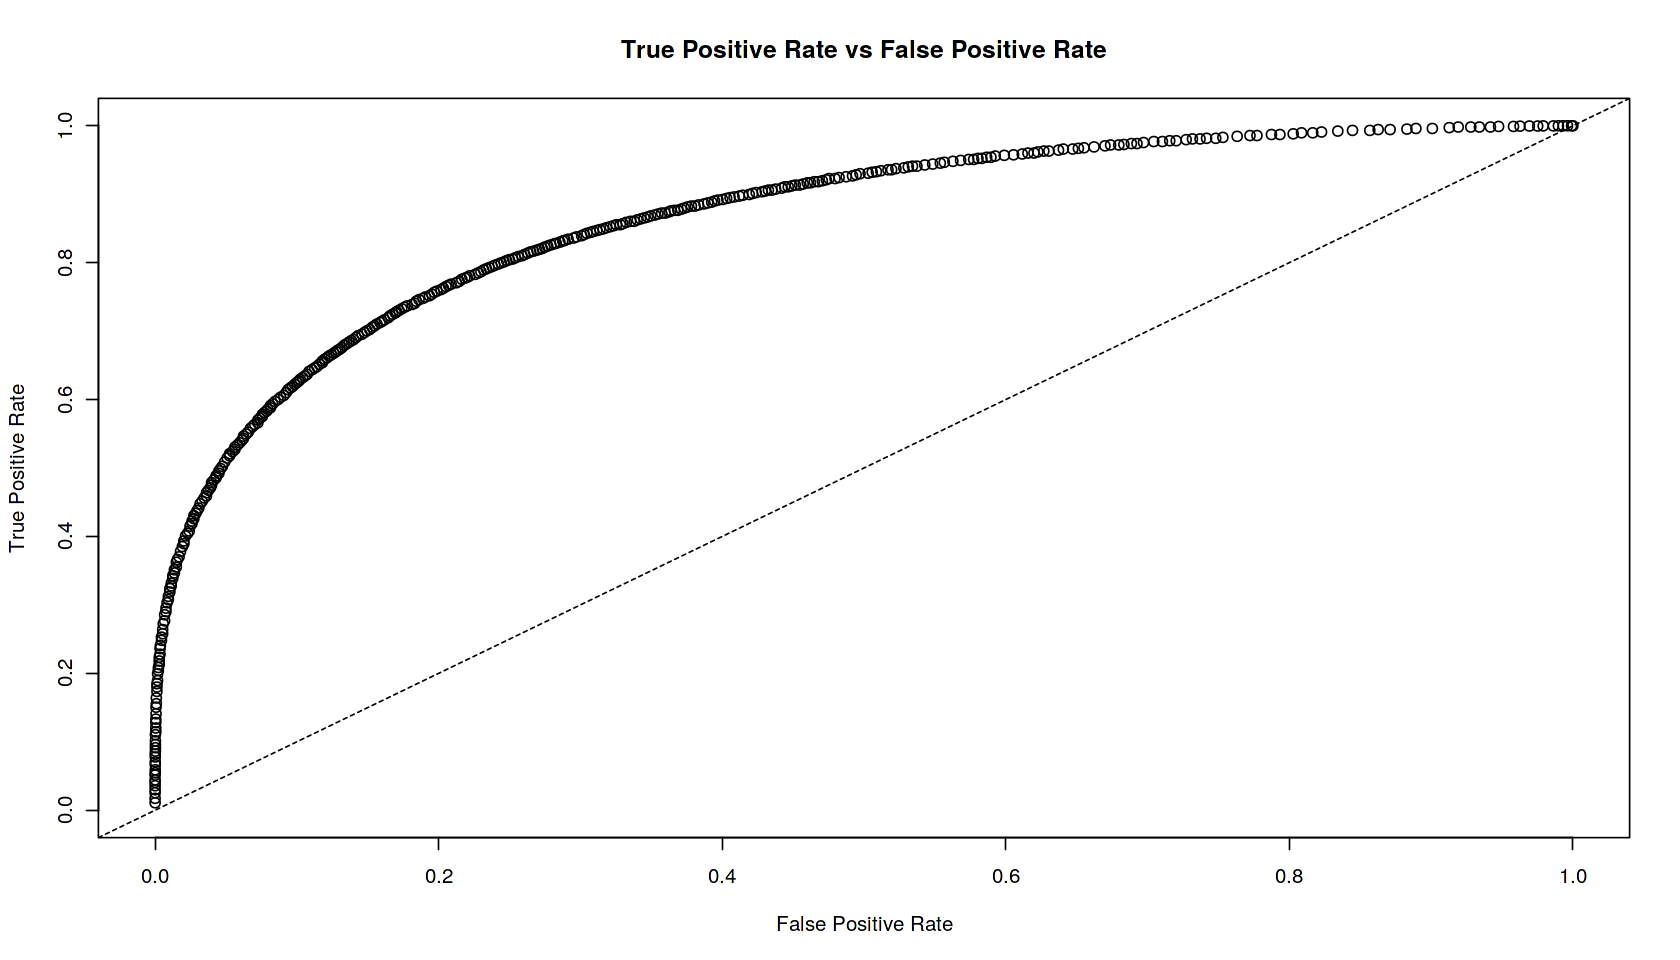

In [20]:
pref <- h2o.performance(leader_model,tr_dd)
plot(pref,type="roc")
pref

H2OBinomialMetrics: stackedensemble

MSE:  0.1435781
RMSE:  0.378917
LogLoss:  0.4477184
Mean Per-Class Error:  0.2845219
AUC:  0.7856721
AUCPR:  0.5673061
Gini:  0.5713441

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           0     1    Error          Rate
0      27475 10012 0.267079  =10012/37487
1       3520  8137 0.301964   =3520/11657
Totals 30995 18149 0.275354  =13532/49144

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold        value idx
1                       max f1  0.250598     0.545997 258
2                       max f2  0.125652     0.673732 349
3                 max f0point5  0.396025     0.538083 176
4                 max accuracy  0.538726     0.793484 116
5                max precision  0.925436     1.000000   0
6                   max recall  0.080106     1.000000 399
7              max specificity  0.925436     1.000000   0
8             max absolute_mcc  0.316444     0.3

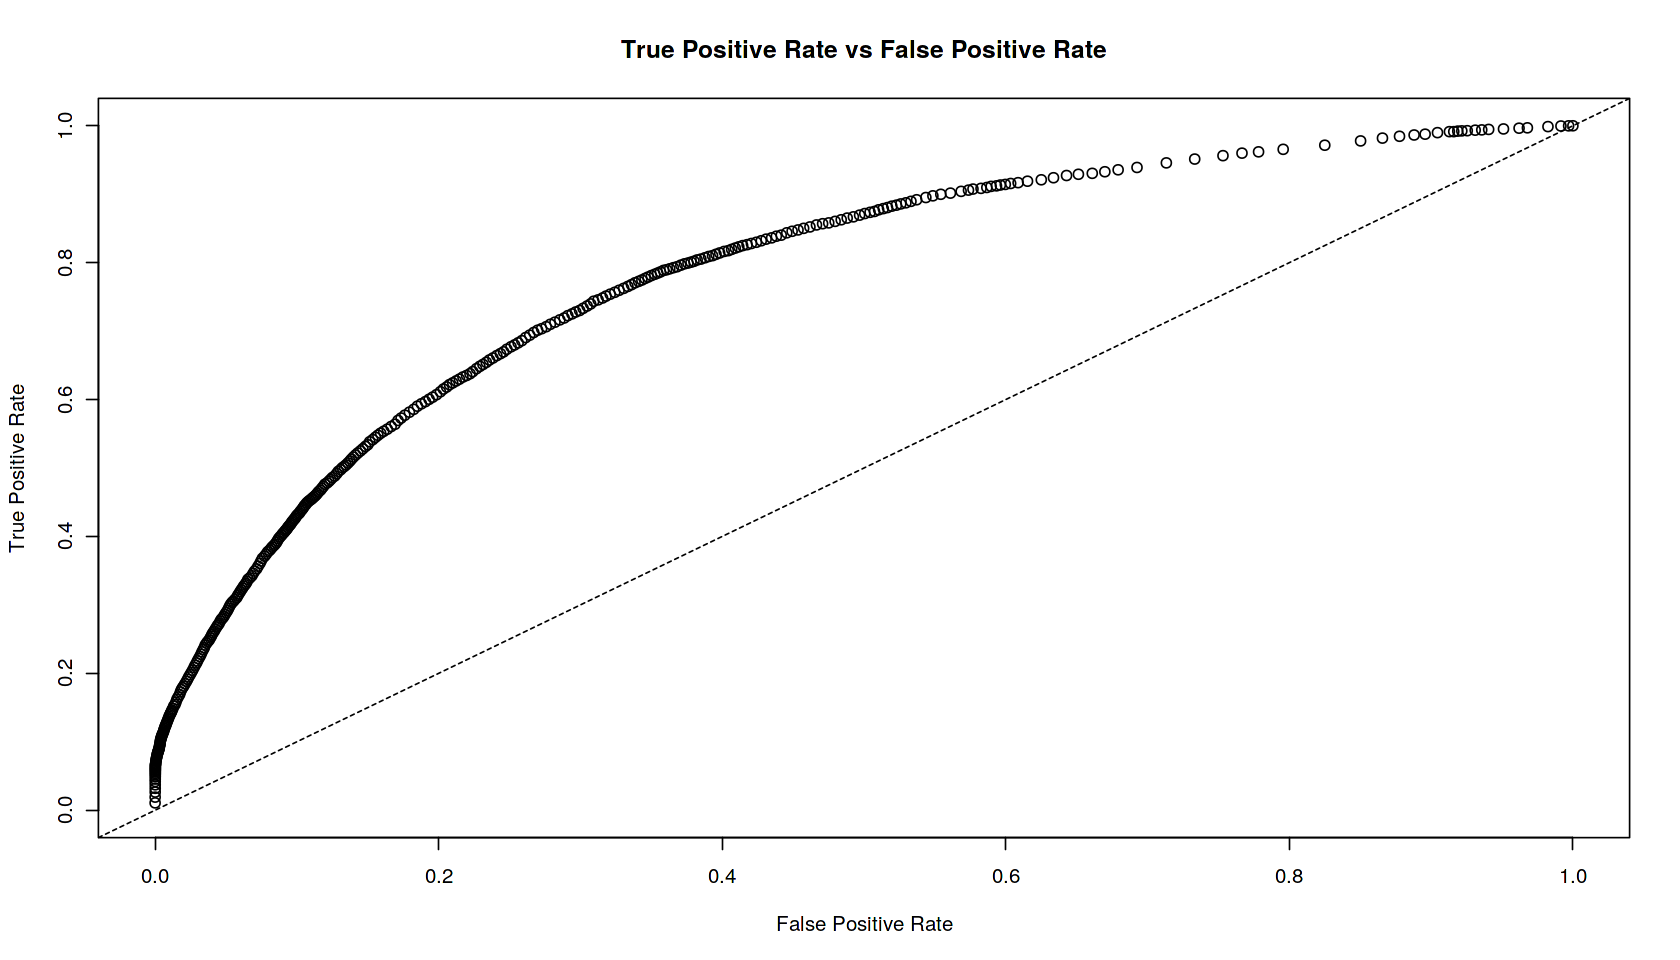

In [21]:
pref <- h2o.performance(leader_model,va_dd)
plot(pref,type="roc")
pref

In [22]:
yhat <- h2o.predict(leader_model,te_dd) %>% as_tibble()
summary(yhat)

  |======================================================================| 100%


 predict         p0                p1         
 0:66776   Min.   :0.07315   Min.   :0.07815  
 1:38536   1st Qu.:0.68509   1st Qu.:0.10219  
           Median :0.82281   Median :0.17719  
           Mean   :0.74804   Mean   :0.25196  
           3rd Qu.:0.89781   3rd Qu.:0.31491  
           Max.   :0.92185   Max.   :0.92685  

In [23]:
submission <- data.frame('ID'=sample_sub$ID,'Is_Lead'=yhat$p1)
filename <- paste('ak_h2o_20_automl_bag_imp_nvz_dummy',format(Sys.time(),"%Y%m%d%H%M%s"),sep = '_')
write.csv(submission,paste0(filename,'.csv',collapse = ''),row.names = FALSE)

In [24]:
tr_s <- bake(prep(bagg_impute),new_data = NULL)
va_s <- bake(prep(bagg_impute),new_data = va_sample)
te_s <- bake(prep(bagg_impute),new_data = test)

In [25]:
str(tr_s)

tibble[,10] [196,581 × 10] (S3: tbl_df/tbl/data.frame)
 $ Gender             : Factor w/ 2 levels "Female","Male": 1 1 1 1 2 2 1 1 2 1 ...
 $ Age                : num [1:196581] 73 30 56 30 56 62 48 55 53 27 ...
 $ Region_Code        : Factor w/ 35 levels "RG250","RG251",..: 19 28 19 33 12 33 16 19 5 28 ...
 $ Occupation         : Factor w/ 4 levels "Entrepreneur",..: 2 3 4 3 4 2 4 4 4 3 ...
 $ Channel_Code       : Factor w/ 4 levels "X1","X2","X3",..: 3 1 3 1 1 3 3 2 3 1 ...
 $ Vintage            : num [1:196581] 43 32 26 33 32 20 13 49 123 20 ...
 $ Credit_Product     : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 2 1 2 1 1 ...
 $ Avg_Account_Balance: num [1:196581] 13.9 13.3 14.2 13.7 13.2 ...
 $ Is_Active          : Factor w/ 2 levels "No","Yes": 1 1 2 1 2 2 2 1 2 2 ...
 $ Is_Lead            : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 1 1 ...


In [26]:
tr_dd <- as.h2o(tr_s)
va_dd <- as.h2o(va_s)
te_dd <- as.h2o(te_s)

X <- colnames(te_s)
Y <- "Is_Lead"
X

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


[1] "Gender"              "Age"                 "Region_Code"        
[4] "Occupation"          "Channel_Code"        "Vintage"            
[7] "Credit_Product"      "Avg_Account_Balance" "Is_Active"

In [27]:
almname <- paste('ak_h2o_automl',format(Sys.time(),"%d%H%M%S"),sep = '_')
autoML <- h2o.automl(X,Y,training_frame = tr_dd,
                     validation_frame = va_dd,seed=223, 
                     max_models=10,stopping_metric=c("AUC"),balance_classes=TRUE)

  |                                                                      |   0%
  |======================================================================| 100%


In [28]:
autoML@leader

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_AllModels_AutoML_20210529_184924 
NULL


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.1334925
RMSE:  0.3653663
LogLoss:  0.4202993
Mean Per-Class Error:  0.2625826
AUC:  0.8171687
AUCPR:  0.6240509
Gini:  0.6343375

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
            0     1    Error           Rate
0      120099 29851 0.199073  =29851/149950
1       15206 31425 0.326092   =15206/46631
Totals 135305 61276 0.229203  =45057/196581

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold         value idx
1                       max f1  0.266221      0.582446 250
2                       max f2  0.132604      0.693692 329
3                 max f0point5  0.504783      0.586758 142
4                 max accuracy  0.509872      0.809860 140
5                max precision  0.947469      1.000000   

In [29]:
autoML@leaderboard

                                             model_id       auc   logloss
1    StackedEnsemble_AllModels_AutoML_20210529_184924 0.7999073 0.4340355
2 StackedEnsemble_BestOfFamily_AutoML_20210529_184924 0.7995475 0.4343015
3                        GBM_1_AutoML_20210529_184924 0.7991408 0.4331331
4                        GBM_2_AutoML_20210529_184924 0.7987617 0.4339400
5                    XGBoost_3_AutoML_20210529_184924 0.7983149 0.4316264
6                        GBM_3_AutoML_20210529_184924 0.7982450 0.4340258
      aucpr mean_per_class_error      rmse       mse
1 0.5950898            0.2732190 0.3723842 0.1386700
2 0.5946074            0.2747816 0.3725215 0.1387723
3 0.5937641            0.2733252 0.3721698 0.1385103
4 0.5931767            0.2737710 0.3724764 0.1387387
5 0.5925855            0.2737428 0.3718954 0.1383062
6 0.5926136            0.2735704 0.3725438 0.1387889

[12 rows x 7 columns] 

In [30]:
leader_name <- as.tibble(autoML@leaderboard) %>% dplyr::slice(1) %>% dplyr::pull(model_id)

leader_model <- h2o.getModel(leader_name)

save(autoML, file="automlv2_20210528.rda")

H2OBinomialMetrics: stackedensemble

MSE:  0.1334925
RMSE:  0.3653663
LogLoss:  0.4202993
Mean Per-Class Error:  0.2625826
AUC:  0.8171687
AUCPR:  0.6240509
Gini:  0.6343375

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
            0     1    Error           Rate
0      120099 29851 0.199073  =29851/149950
1       15206 31425 0.326092   =15206/46631
Totals 135305 61276 0.229203  =45057/196581

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold         value idx
1                       max f1  0.266221      0.582446 250
2                       max f2  0.132604      0.693692 329
3                 max f0point5  0.504783      0.586758 142
4                 max accuracy  0.509872      0.809860 140
5                max precision  0.947469      1.000000   0
6                   max recall  0.063677      1.000000 399
7              max specificity  0.947469      1.000000   0
8             max absolute_mcc 

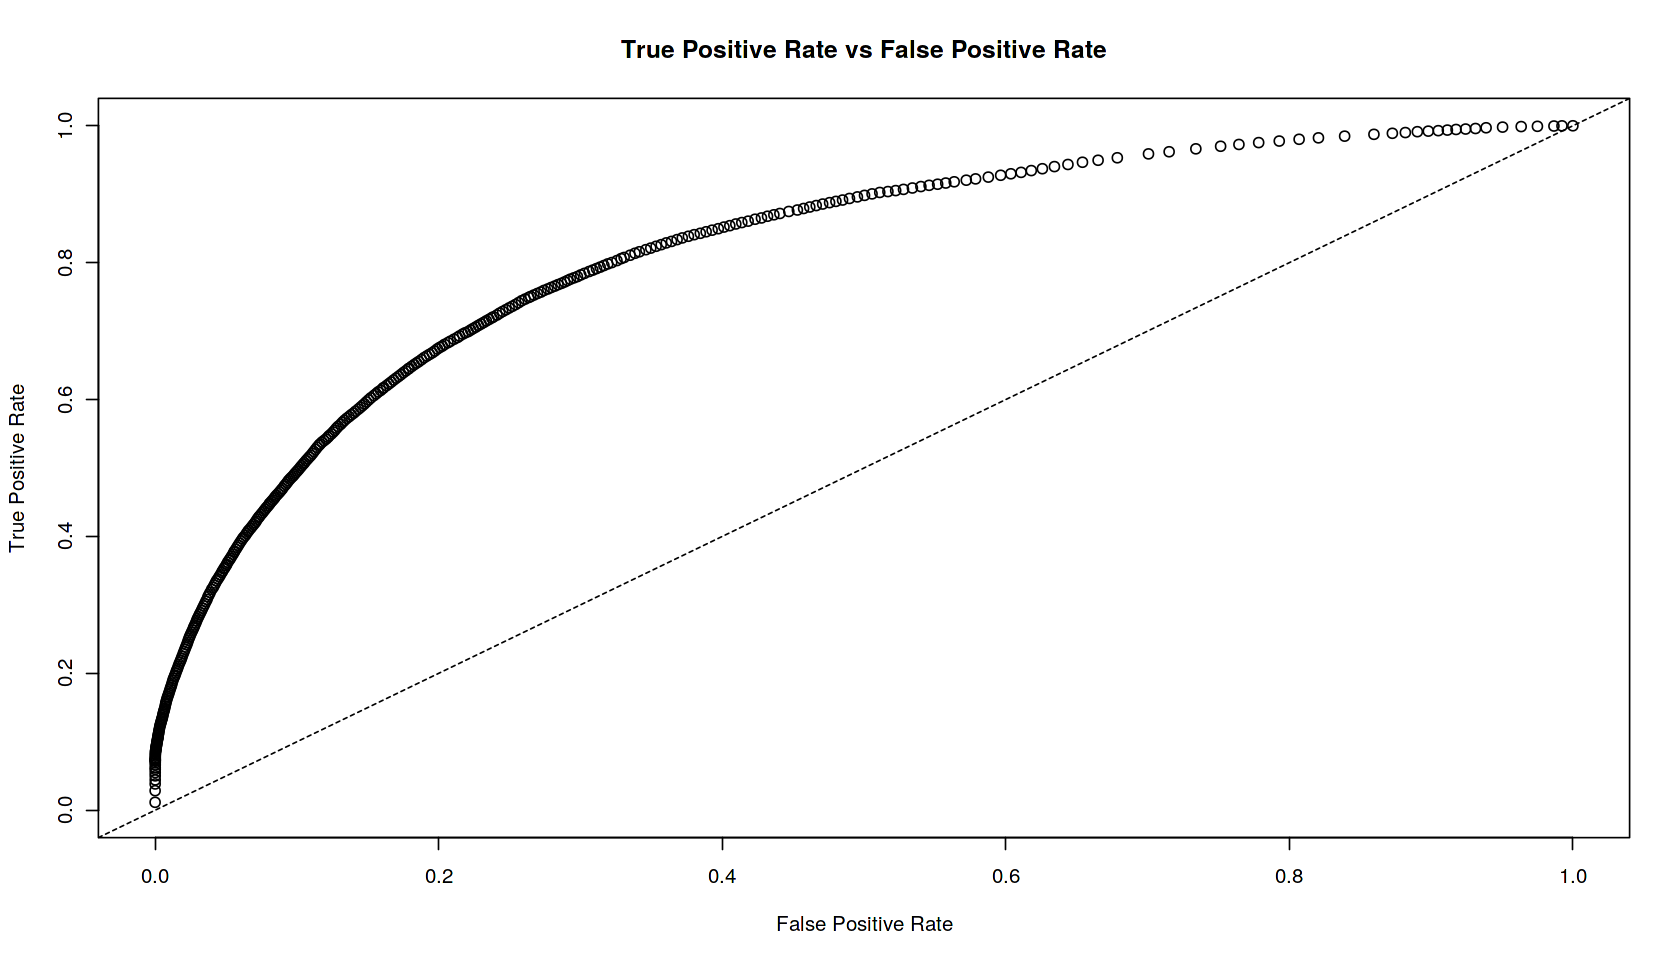

In [31]:
pref <- h2o.performance(leader_model,tr_dd)
plot(pref,type="roc")
pref

H2OBinomialMetrics: stackedensemble

MSE:  0.1389533
RMSE:  0.3727643
LogLoss:  0.4345353
Mean Per-Class Error:  0.2717129
AUC:  0.7998141
AUCPR:  0.5923865
Gini:  0.5996282

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           0     1    Error          Rate
0      29220  8267 0.220530   =8267/37487
1       3764  7893 0.322896   =3764/11657
Totals 32984 16160 0.244811  =12031/49144

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold        value idx
1                       max f1  0.247066     0.567495 255
2                       max f2  0.125261     0.681073 330
3                 max f0point5  0.417323     0.560240 170
4                 max accuracy  0.532826     0.799935 123
5                max precision  0.947534     1.000000   0
6                   max recall  0.063517     1.000000 399
7              max specificity  0.947534     1.000000   0
8             max absolute_mcc  0.295715     0.

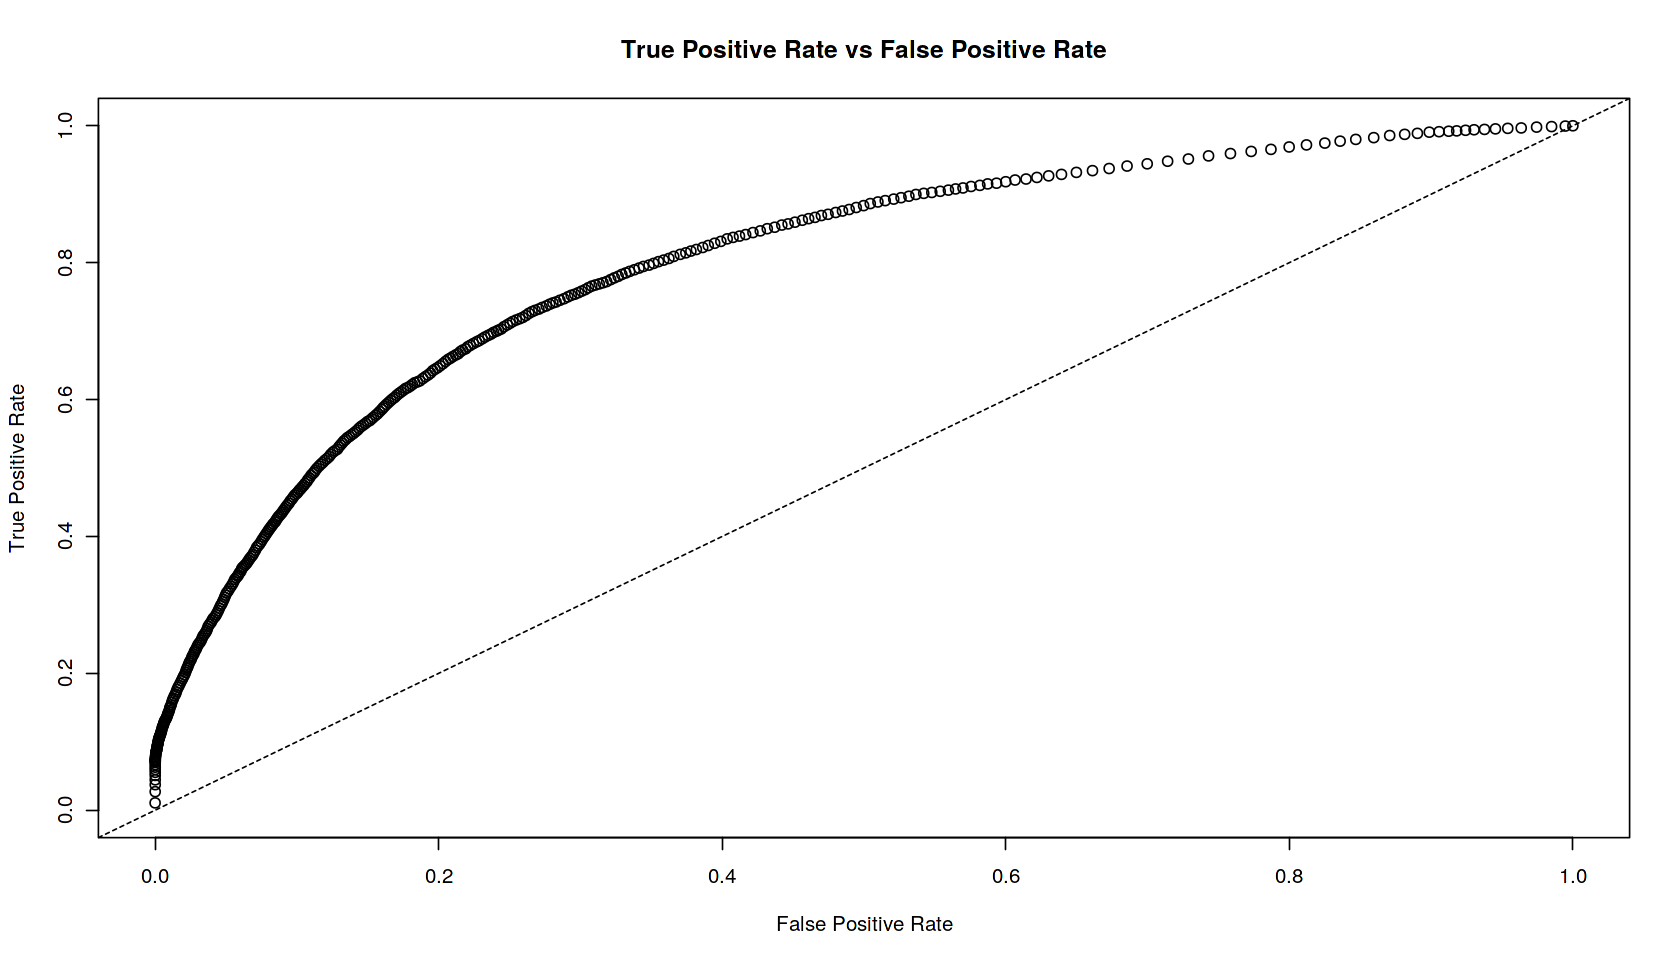

In [32]:
pref <- h2o.performance(leader_model,va_dd)
plot(pref,type="roc")
pref

In [33]:
yhat <- h2o.predict(leader_model,te_dd) %>% as_tibble()
summary(yhat)

  |======================================================================| 100%


 predict         p0                p1         
 0:70761   Min.   :0.05093   Min.   :0.06182  
 1:34551   1st Qu.:0.67223   1st Qu.:0.08431  
           Median :0.86302   Median :0.13698  
           Mean   :0.76303   Mean   :0.23697  
           3rd Qu.:0.91569   3rd Qu.:0.32777  
           Max.   :0.93818   Max.   :0.94907  

In [34]:
submission <- data.frame('ID'=sample_sub$ID,'Is_Lead'=yhat$p1)
filename <- paste('ak_h2o_20_automl_bag_imp',format(Sys.time(),"%Y%m%d%H%M%s"),sep = '_')
write.csv(submission,paste0(filename,'.csv',collapse = ''),row.names = FALSE)